In [110]:
import numpy as np
from scipy.stats import multivariate_normal , pearsonr
from scipy.spatial.distance import cdist

from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

We start off by generating a histogram presenting three different peaks.

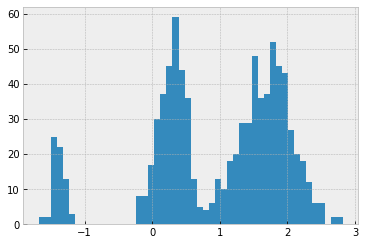

In [111]:
# Generate data

means = [.3, 1.7, -1.4]
scales = [.2, .4, .1]
n_samples = [300, 485, 67]

data = np.concatenate([np.random.normal(mean, scale, size) for mean, scale, size in zip(means, scales, n_samples)])

_ = plt.hist(data, bins = 50)

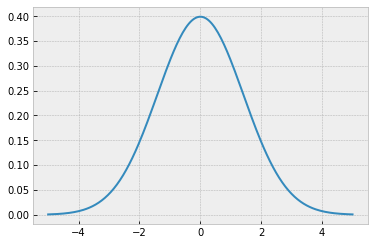

In [112]:
# Class for Gaussian distribution
class Gaussian():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        return (1/(self.sigma*np.sqrt(2*np.pi)))*np.exp(-.5*(x - self.mu)**2/(2*self.sigma**2))


n1 = Gaussian(mu = 0, sigma = 1.)
pdf = n1.pdf(np.linspace(-5, 5, 200))

plt.plot(np.linspace(-5, 5, 200), pdf)
plt.show()

Let's try to fit a single Gaussian to our data and look at the results.

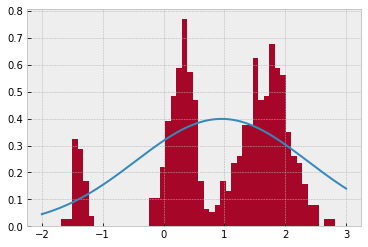

In [113]:
mu = np.mean(data)
std = np.std(data)

g = Gaussian(mu, std)
pdf = g.pdf(np.linspace(-2, 3, 200))

plt.plot(np.linspace(-2, 3, 200), pdf)
_ = plt.hist(data, bins = 50, density=True)
plt.show()

Clearly, the results aren't satisfying, hence the needs to fit multiple gaussians in our data.

In the following, we implement the Gaussian Mixture Model which will fit multiple gaussain distributions to our dataset.

In [143]:
class GMM:
    def __init__(self, k, max_iter=50):
        self.k = k
        self.max_iter = int(max_iter) 

    def initialize(self, X):
        
        self.shape = X.shape 
        self.n, self.m = self.shape 
        # initial weights given to each cluster are stored in phi.
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j).
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        # dataset is divided randomly into k parts of unequal sizes.
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        # initial value of mean of k Gaussians.
        self.mu = [X[row_index,:] for row_index in random_row] 
        # initial value of covariance matrix of k Gaussians.
        self.sigma = [np.cov(X.T) for _ in range(self.k)] 

    def e_step(self, X):
        # updated weights or P(Xi/Ci=j).
        self.weights = self.predict_proba(X)
        # update weights given to each cluster.
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        # M-Step: update mean and covariance with phi and weights remaining constant.
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X):
        # initialise parameters.
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            

    # predicts probability of each data point wrt each cluster
    def predict_proba(self, X):
        # predicts probability of each data point belonging to each cluster.
        likelihood = np.zeros( (self.n, self.k) ) # Creates a n*k matrix denoting probability of each point w.r.t each cluster. 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i], allow_singular=True)
            likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        # Hard clustering by taking argmax of probabilities.
        return np.argmax(weights, axis=1)
    
    def AIC(self, X):
        # Calculate AIC score on fitted data.
        labels = self.predict(X)
        L = 0
        
        for i in range(X.shape[0]):
            sigma = self.sigma[labels[i]]
            L += np.dot(X[i], np.matmul(np.linalg.inv(sigma), X[i]))
            
        AIC = 2*self.k*X.shape[1] - L/X.shape[0]
        return AIC

    def BIC(self, X):
        # Calculate BIC score on fitted data.
        labels = self.predict(X)
        L = 0
        
        for i in range(X.shape[0]):
            sigma = self.sigma[labels[i]]
            L += np.dot(X[i], np.matmul(np.linalg.inv(sigma), X[i]))
            
        BIC = self.k*X.shape[1]*np.log(X.shape[0]) - L/X.shape[0]
        return BIC
    
    def merge(self, X,  criterion = 'distance', epsilon = 2.):
        assert criterion in ['distance', 'parameter', 'correlation']
        labels = self.predict(X)
        if criterion == 'distance':

            distances = np.triu(cdist(self.mu, self.mu)).T
            distances[np.where(distances == 0)] = 99999
            min_id = np.argmin(distances)
            x, y = min_id//distances.shape[0], min_id%distances.shape[1]
            val =  np.linalg.norm(self.mu[y] - self.mu[x], ord = 1)
            
            if val < epsilon:
                self.mu_new = [mu for i, mu in enumerate(self.mu) if not i == x] 
                nx = len(np.where(labels == x)[0])
                ny = len(np.where(labels == y)[0])
                self.mu_new[y] = (nx*self.mu[x]+ny*self.mu[y])/(nx+ny)
                self.sigma_new = [sigma for i, sigma in enumerate(self.sigma) if not i == x] 
                self.sigma_new[y] = (self.sigma[x]*nx+self.sigma[y]*ny)/(nx+ny)
                self.phi_new = [p for i, p in enumerate(self.phi) if not i == x]
                self.phi_new[y] = self.phi[x] + self.phi[y]

                # update
                self.mu = self.mu_new
                self.sigma = self.sigma_new
                self.k = self.k - 1
                self.phi = np.array(self.phi_new)
                print(f'Merged clusters {x} and {y} using {criterion} criterion.')
                
        elif criterion == 'parameter':
            
            variances = 99999*np.ones((self.k, self.k))
            for i in range(self.k):
                for j in range(i+1):
                    pts_ids = np.where((labels == i) | (labels == j))[0]
                    variances[i, j] = np.std(X[pts_ids])**2
            
            min_id = np.argmin(variances)
            x, y = min_id//variances.shape[0], min_id%variances.shape[1]
            
            if variances[x, y] < variances[x, x] + variances[y, y] - epsilon:
                self.mu_new = [mu for i, mu in enumerate(self.mu) if not i == x]    
                nx = len(np.where(labels == x)[0])
                ny = len(np.where(labels == y)[0])
                self.mu_new[y] = (nx*self.mu[x]+ny*self.mu[y])/(nx+ny)
                self.sigma_new = [sigma for i, sigma in enumerate(self.sigma) if not i == x] 
                self.sigma_new[y] = (self.sigma[x]*nx+self.sigma[y]*ny)/(nx+ny)
                self.phi_new = [p for i, p in enumerate(self.phi) if not i == x]
                self.phi_new[y] = self.phi[x] + self.phi[y]

                # update
                self.mu = self.mu_new
                self.sigma = self.sigma_new
                self.k = self.k - 1
                self.phi = np.array(self.phi_new)
                
                print(f'Merged clusters {x} and {y} using {criterion} criterion.')
                
        elif criterion == 'correlation':
            probas = self.predict_proba(X)
            correlations = -99999*np.ones((self.k, self.k))
            for i in range(self.k):
                for j in range(i):
                    # pts_i = np.where(labels == i)[0]
                    # pts_j = np.where(labels == j)[0]

                    corr, _ = pearsonr(probas[:, i], probas[:, j])
                    correlations[i, j] = corr
            min_id = np.argmax(correlations)
            x, y = min_id//correlations.shape[0], min_id%correlations.shape[1]
            if correlations[x, y] > 1 - epsilon:
                self.mu_new = [mu for i, mu in enumerate(self.mu) if not i == x] 
                nx = len(np.where(labels == x)[0])
                ny = len(np.where(labels == y)[0])
                self.mu_new[y] = (nx*self.mu[x]+ny*self.mu[y])/(nx+ny)
                self.sigma_new = [sigma for i, sigma in enumerate(self.sigma) if not i == x] 
                self.sigma_new[y] = (self.sigma[x]*nx+self.sigma[y]*ny)/(nx+ny)
                self.phi_new = [p for i, p in enumerate(self.phi) if not i == x]
                self.phi_new[y] = self.phi[x] + self.phi[y]

                # update
                self.mu = self.mu_new
                self.sigma = self.sigma_new
                self.k = self.k - 1
                self.phi = np.array(self.phi_new)
                print(f'Merged clusters {x} and {y} using {criterion} criterion.')
                        


Fit the GMM model to our histogram data then merge two clusters and check the results.

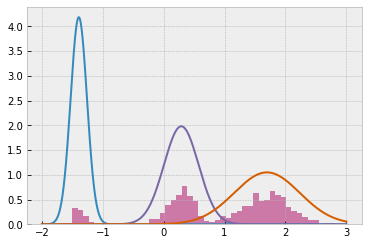

In [145]:
X = data[None].T

model =  GMM(k = 3)
model.fit(X)

means = model.mu
sigmas= model.sigma

p_cond = [Gaussian(mean, np.sqrt(var)) for mean, var in zip(means, sigmas)]

for g in p_cond:
    pdf = g.pdf(np.linspace(-2, 3, 2000))

    plt.plot(np.linspace(-2, 3, 2000), pdf)
    _ = plt.hist(data, bins = 50, density=True)
plt.show()

In [146]:
print('Before merging | mean : ', model.mu, ', covariance : ',  model.sigma)
model.merge(X, criterion = 'correlation')
print('Before merging | mean : ', model.mu, ', covariance : ',  model.sigma)

Before merging | mean :  [array([-1.39407739]), array([0.28931129]), array([1.6968883])] , covariance :  [array(0.00909775), array(0.0406134), array(0.14471084)]
Merged clusters 1 and 0 using correlation criterion.
Before merging | mean :  [array([-0.01469691]), array([1.6968883])] , covariance :  [array([[0.0349219]]), array([[0.14471084]])]


Merged clusters 2 and 1 using distance criterion.


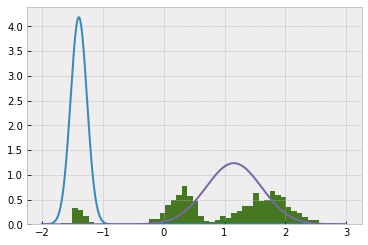

In [147]:
X = data[None].T

model =  GMM(k = 3)
model.fit(X)

model.merge(X, criterion = 'distance')

means = model.mu
sigmas= model.sigma

p_cond = [Gaussian(mean[0], np.sqrt(var)[0]) for mean, var in zip(means, sigmas)]

for g in p_cond:
    pdf = g.pdf(np.linspace(-2, 3, 2000))

    plt.plot(np.linspace(-2, 3, 2000), pdf)
    _ = plt.hist(data, bins = 50, density=True)
plt.show()

Track AIC and BIC scores to select the number of clusters.

Model order : 1 | AIC : 0.09027129722227123 | BIC : 4.837857824051587
Model order : 2 | AIC : -13.7085612685656 | BIC : -4.213388214906969
Model order : 3 | AIC : -23.795084921779335 | BIC : -9.55232534129139
Model order : 4 | AIC : -22.91912027355854 | BIC : -3.928774166241279
Model order : 5 | AIC : -21.020845700232773 | BIC : 2.7170869339138015


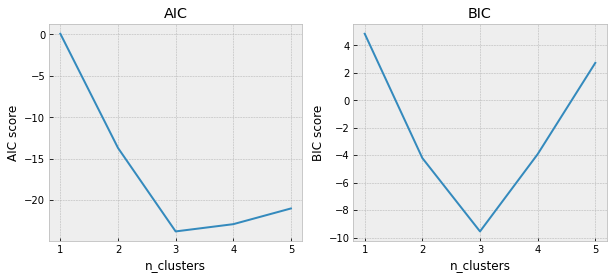

In [148]:
# AIC to validate number of clusters.
orders = [1, 2, 3, 4, 5]
AIC = []
BIC = []
for k in orders:
    model = GMM(k = k)
    model.fit(X)
    aic_score = model.AIC(X)
    bic_score = model.BIC(X)
    AIC.append(aic_score)
    BIC.append(bic_score)
    print(f'Model order : {k} | AIC : {aic_score} | BIC : {bic_score}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(orders, AIC)
ax[0].set_title('AIC')
ax[0].set_xlabel('n_clusters')
ax[0].set_ylabel('AIC score')

ax[1].plot(orders, BIC)
ax[1].set_title('BIC')
ax[1].set_xlabel('n_clusters')
ax[1].set_ylabel('BIC score')

plt.show()

Test our model on other data

In [123]:
data1 = DataFrame.to_numpy(read_csv('data_MM_1.csv'))

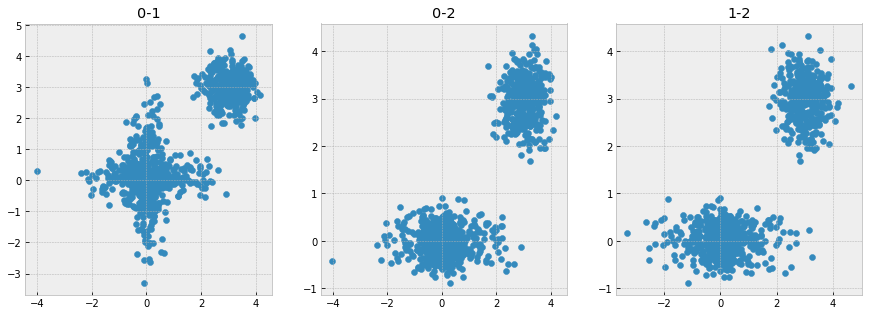

In [124]:
fig, ax = plt.subplots(1, 3 , figsize = (15, 5))
ax[0].scatter(data1[:, 0], data1[:, 1])
ax[0].set_title('0-1')
ax[1].scatter(data1[:, 0], data1[:, 2])
ax[1].set_title('0-2')
ax[2].scatter(data1[:, 1], data1[:, 2])
ax[2].set_title('1-2')
plt.show()

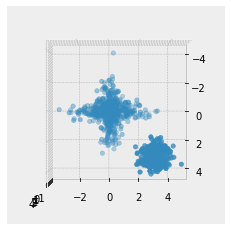

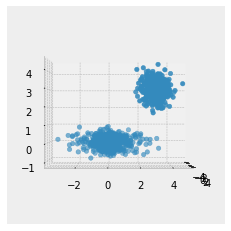

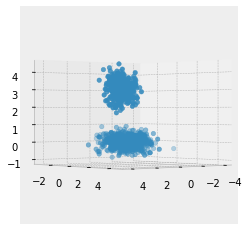

In [125]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(90, 0)
ax.scatter(data1[:, 0], data1[:, 1], data1[:, 2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 0)
ax.scatter(data1[:, 0], data1[:, 1], data1[:, 2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 50)
ax.scatter(data1[:, 0], data1[:, 1], data1[:, 2])

Model order : 1 | AIC : 2.387706897864275 | BIC : 17.107971233809934
Model order : 2 | AIC : -41.82855266911048 | BIC : -12.388023997219157
Model order : 3 | AIC : -38.762087219115614 | BIC : 5.398705788721372
Model order : 4 | AIC : -30.944037845465076 | BIC : 27.937019498317568
Model order : 5 | AIC : -102.87688693254302 | BIC : -29.2755652528147
Model order : 6 | AIC : -27.948232164249667 | BIC : 60.373353851424305
Model order : 7 | AIC : -52.703675920552854 | BIC : 50.33817443106679
Model order : 8 | AIC : -13.851142220655518 | BIC : 103.91097246690977


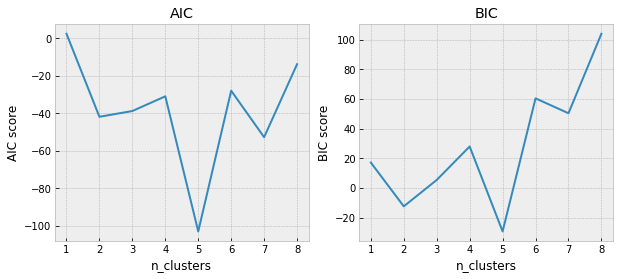

In [126]:
# AIC to validate number of clusters.
orders = [1, 2, 3, 4, 5, 6, 7, 8]
AIC = []
BIC = []
for k in orders:
    model = GMM(k = k)
    model.fit(data1)
    aic_score = model.AIC(data1)
    bic_score = model.BIC(data1)
    AIC.append(aic_score)
    BIC.append(bic_score)
    print(f'Model order : {k} | AIC : {aic_score} | BIC : {bic_score}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(orders, AIC)
ax[0].set_title('AIC')
ax[0].set_xlabel('n_clusters')
ax[0].set_ylabel('AIC score')

ax[1].plot(orders, BIC)
ax[1].set_title('BIC')
ax[1].set_xlabel('n_clusters')
ax[1].set_ylabel('BIC score')

plt.show()

In [149]:
model = GMM(k = 5)
model.fit(data1)

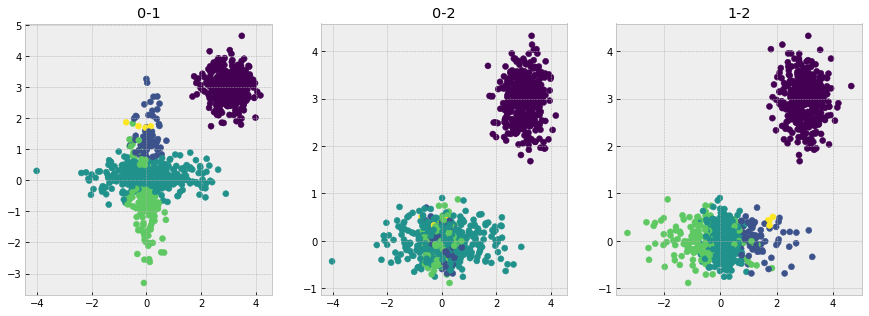

In [150]:
predictions = model.predict(data1)

fig, ax = plt.subplots(1, 3 , figsize = (15, 5))
ax[0].scatter(data1[:, 0], data1[:, 1], c = predictions)
ax[0].set_title('0-1')
ax[1].scatter(data1[:, 0], data1[:, 2], c = predictions)
ax[1].set_title('0-2')
ax[2].scatter(data1[:, 1], data1[:, 2], c = predictions)
ax[2].set_title('1-2')
plt.show()

Now let's see what K-means does to classify this data.

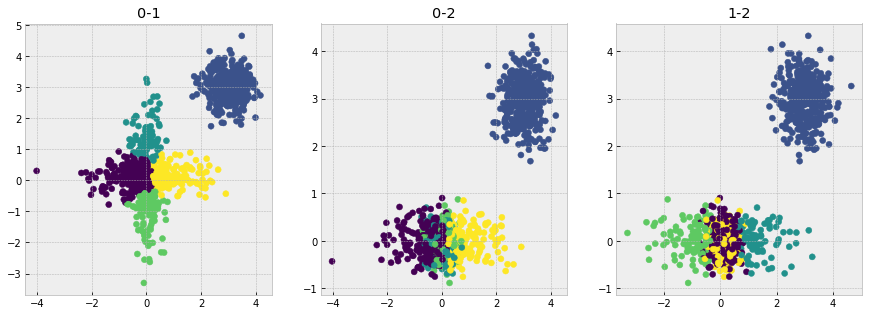

In [151]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 5).fit(data1)

predictions = model.predict(data1)

fig, ax = plt.subplots(1, 3 , figsize = (15, 5))
ax[0].scatter(data1[:, 0], data1[:, 1], c = km.labels_)
ax[0].set_title('0-1')
ax[1].scatter(data1[:, 0], data1[:, 2], c = km.labels_)
ax[1].set_title('0-2')
ax[2].scatter(data1[:, 1], data1[:, 2], c = km.labels_)
ax[2].set_title('1-2')
plt.show()

# Second dataset

In [152]:
data2 = DataFrame.to_numpy(read_csv('data_MM_2.csv'))

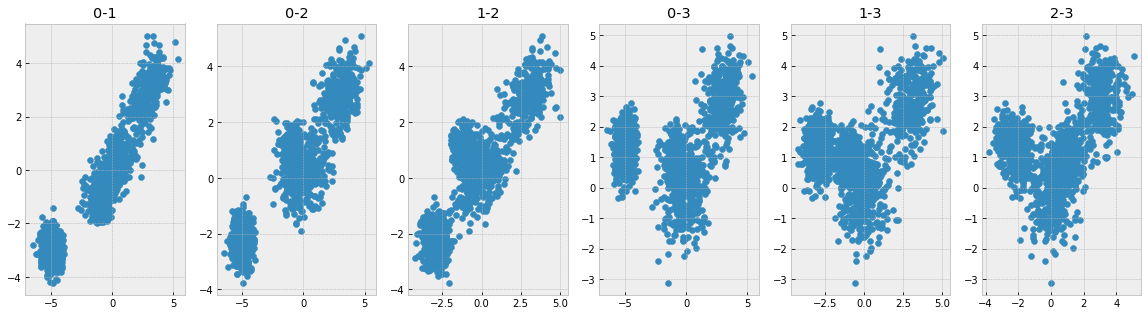

In [153]:
predictions = model.predict(data1)

fig, ax = plt.subplots(1, 6 , figsize = (20, 5))
ax[0].scatter(data2[:, 0], data2[:, 1])
ax[0].set_title('0-1')
ax[1].scatter(data2[:, 0], data2[:, 2])
ax[1].set_title('0-2')
ax[2].scatter(data2[:, 1], data2[:, 2])
ax[2].set_title('1-2')
ax[3].scatter(data2[:, 0], data2[:, 3])
ax[3].set_title('0-3')
ax[4].scatter(data2[:, 1], data2[:, 3])
ax[4].set_title('1-3')
ax[5].scatter(data2[:, 2], data2[:, 3])
ax[5].set_title('2-3')
plt.show()

Model order : 1 | AIC : 1.6498544673062083 | BIC : 22.9000684597166
Model order : 2 | AIC : 5.486920230000177 | BIC : 47.987348214820955
Model order : 3 | AIC : -68.88566455591095 | BIC : -5.135022578679781
Model order : 4 | AIC : -66.83201975774138 | BIC : 18.168836211900185
Model order : 5 | AIC : -61.95514185166448 | BIC : 44.29592811038748
Model order : 6 | AIC : -50.90266381471217 | BIC : 76.59862013975017
Model order : 7 | AIC : -59.16168666877782 | BIC : 89.58981127809493
Model order : 8 | AIC : -37.2339647382869 | BIC : 132.7677472009962


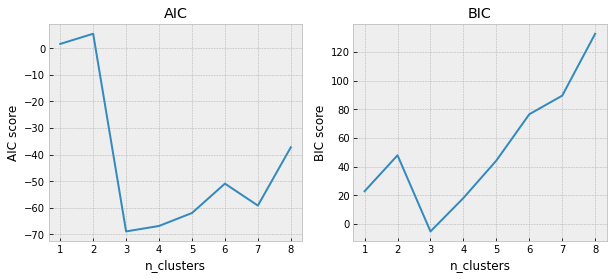

In [154]:
# AIC to validate number of clusters.
orders = [1, 2, 3, 4, 5, 6, 7, 8]
AIC = []
BIC = []
for k in orders:
    model = GMM(k = k)
    model.fit(data2)
    aic_score = model.AIC(data2)
    bic_score = model.BIC(data2)
    AIC.append(aic_score)
    BIC.append(bic_score)
    print(f'Model order : {k} | AIC : {aic_score} | BIC : {bic_score}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(orders, AIC)
ax[0].set_title('AIC')
ax[0].set_xlabel('n_clusters')
ax[0].set_ylabel('AIC score')

ax[1].plot(orders, BIC)
ax[1].set_title('BIC')
ax[1].set_xlabel('n_clusters')
ax[1].set_ylabel('BIC score')

plt.show()

# Digits dataset

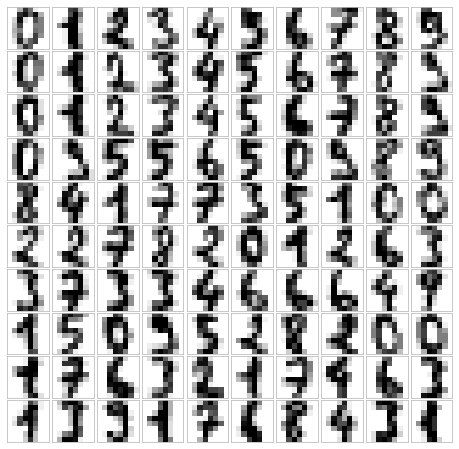

In [155]:
from sklearn.datasets import load_digits
digits = load_digits()

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Dimensionality reduction using PCA.

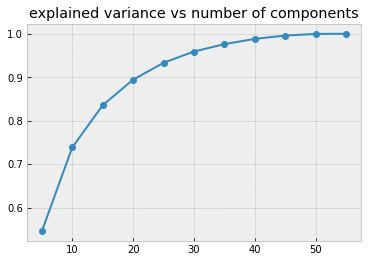

In [156]:
from sklearn.decomposition import PCA

n_components = np.arange(5, 60, 5)
variances = []

for nc in n_components:
    pca = PCA(n_components = nc).fit(digits.data)
    variances.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(n_components, variances, marker = 'o')
plt.title('explained variance vs number of components')
plt.show()


Hence in the following, we will try to keep 30 features.

In [157]:
im_data = PCA(n_components = 30).fit_transform(digits.data)
print(im_data.shape)

(1797, 30)


Model order : 3 | AIC : 119.92670217770589 | BIC : 614.3753519882263
Model order : 6 | AIC : 239.95770517098782 | BIC : 1228.8550047920285
Model order : 9 | AIC : 442.26165268772377 | BIC : 1925.6076021192846
Model order : 12 | AIC : -247067.98625573164 | BIC : -245090.19165648957
Model order : 15 | AIC : 628.055689997892 | BIC : 3100.2989390504936


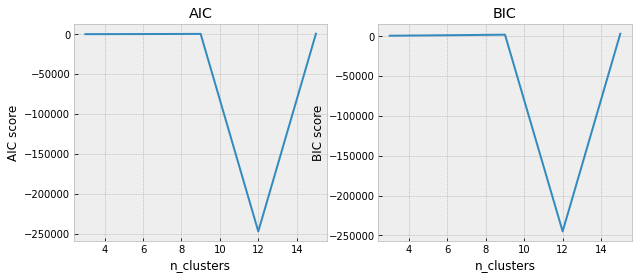

In [158]:
# AIC to validate number of clusters.
orders = [3, 6, 9, 12, 15]
AIC = []
BIC = []
for k in orders:
    model = GMM(k = k)
    model.fit(im_data)
    aic_score = model.AIC(im_data)
    bic_score = model.BIC(im_data)
    AIC.append(aic_score)
    BIC.append(bic_score)
    print(f'Model order : {k} | AIC : {aic_score} | BIC : {bic_score}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(orders, AIC)
ax[0].set_title('AIC')
ax[0].set_xlabel('n_clusters')
ax[0].set_ylabel('AIC score')

ax[1].plot(orders, BIC)
ax[1].set_title('BIC')
ax[1].set_xlabel('n_clusters')
ax[1].set_ylabel('BIC score')

plt.show()

In the following we initialize our clustering with 12 components before merging into 10 components.

In [159]:
model = GMM(k = 12)
model.fit(im_data)

model.merge(im_data, criterion = 'distance', epsilon = 70)
model.merge(im_data, criterion = 'distance', epsilon = 70)

labels = model.predict(im_data)

Merged clusters 10 and 5 using distance criterion.
Merged clusters 3 and 2 using distance criterion.


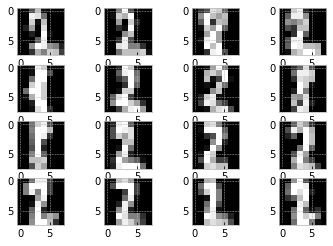

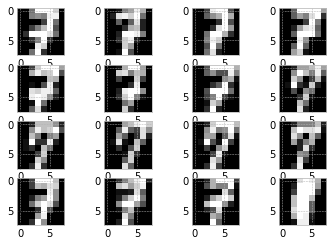

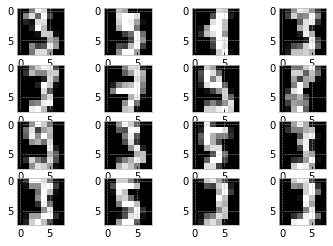

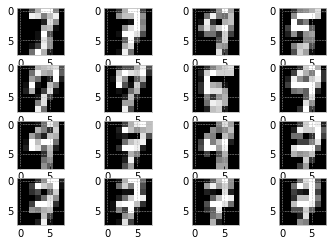

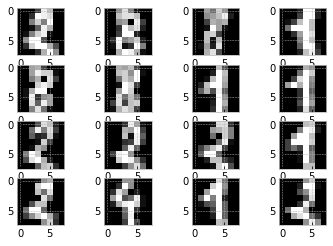

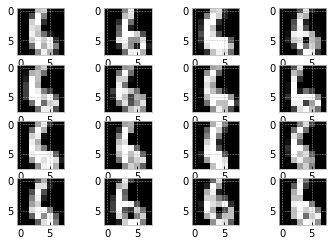

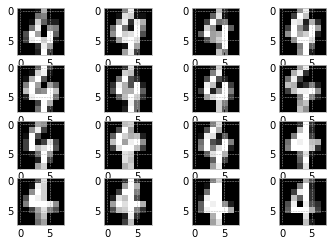

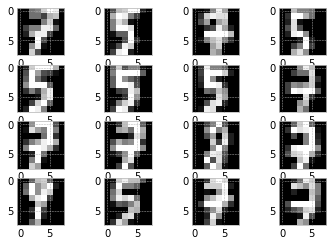

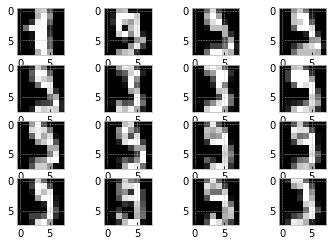

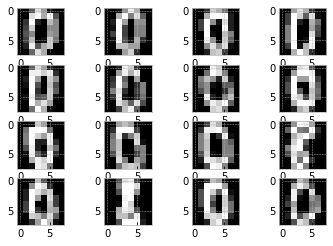

In [162]:
# Plot 16 image per cluster

classes = np.unique(labels)
for c in classes:
    fig, ax = plt.subplots(4, 4)
    _ids = np.where(labels == c)[0][:16]
    imgs = digits.data[_ids]
    for i in range(16):
        x, y = i//4, i%4
        ax[x, y].imshow(imgs[i].reshape((8, 8)), cmap = 'gray')
    plt.show()
